In [5]:
#Imports
import os
from fastai.vision.all import *
# import timm  # Import the 'timm' library to access pre-trained models
set_seed(42)

### Paths to train /validation /test sets

In [6]:
trn_path = r"./dataset/trainValTEMP"
# val_path = r"./dataset/validate" #empty
test_path = r"./dataset/test"

### Start Training

(3264, 2448)


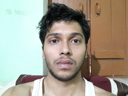

In [11]:
files = get_image_files(trn_path)
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

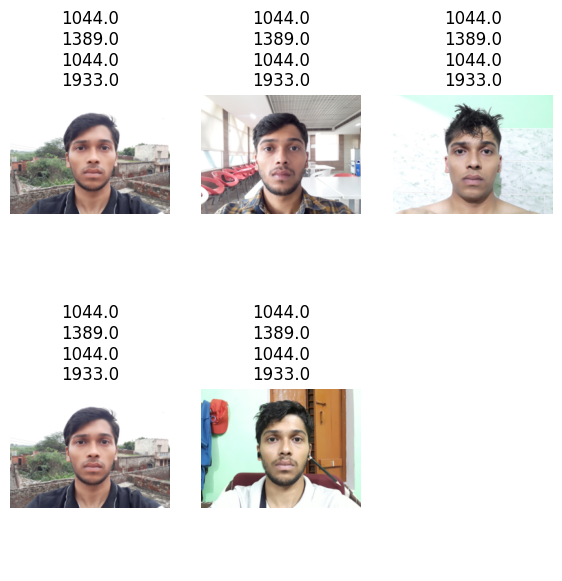

In [13]:
# Function to extract labels from the filenames
# def get_labels(file_path):
#     # Extract numbers after the first underscore
#     file_path = str(file_path)
#     file_path = file_path[0:-4]  # Get filename without extension
#     parts = file_path.split("_")[1:]  # Skip the first part (ID)
#     return list(map(float, parts))  # Convert to floats

def get_leftEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[1])  # Skip the first part (ID)

def get_leftEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[2])  # Skip the first part (ID)

def get_rightEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[3])  # Skip the first part (ID)

def get_rightEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[4])  # Skip the first part (ID)

# print(get_rightEyeR(r"./dataset/train/25_1134_1801_1127_2382.jpg"))

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock),
    n_inp=1,
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=[get_leftEyeR, get_leftEyeC, get_rightEyeR, get_rightEyeC],  # Function to extract labels
    item_tfms=RatioResize(max_sz=248)
)

#Create the DataLoaders
dls = dblock.dataloaders(trn_path, bs=20)  # Adjust batch size as needed

# # Visualize a batch
dls.show_batch(max_n=6, figsize=(7, 7))

In [14]:
def MSELossFlat(input, target):
    return ((input - target)**2).mean()

def leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,0], leftEyeR) + MSELossFlat(input_from_model[:,1], leftEyeC)

def rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,2], rightEyeR) + MSELossFlat(input_from_model[:,3], rightEyeC)

def net_Loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    # print("A: ", leftEyeR)
    # print("B: ", leftEyeR.shape)
    # print("C:", input_from_model)
    # print("D:", input_from_model.shape)
    # print("E:", input_from_model[:,0])
    # print("F:", input_from_model[:,0].shape)
    return leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC) + rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC)

# architecture = 'convnext_small_in22k' #Best Validation MSE : 5509446.000000 (10 epochs) (lr = 0.1)
architecture = 'convnext_tiny_hnf' 

learn = vision_learner(dls, architecture, loss_func=net_Loss, n_out=4).to_fp16()

### Determine the learning rate (Hyperparameter tuning) (⚠: Expensive to run cell, don't run if in a hurry!)

SuggestedLRs(valley=0.10000000149011612, slide=6.309573450380412e-07)

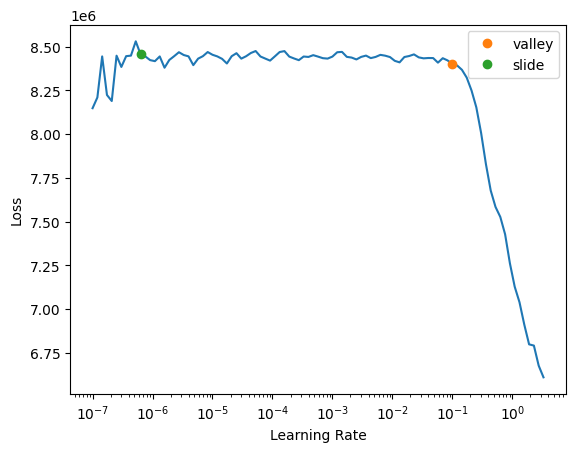

In [12]:
learn.lr_find(suggest_funcs=(valley, slide))

c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.war

epoch,train_loss,valid_loss,time
0,4840771.500000,225481.625000,00:40


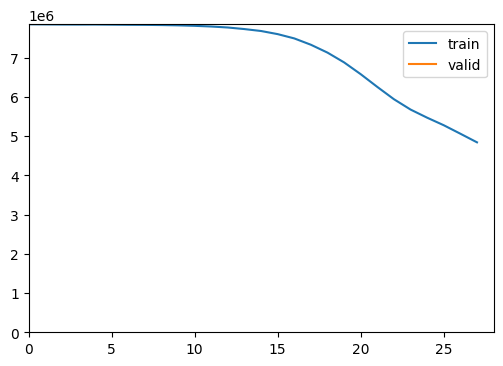

epoch,train_loss,valid_loss,time
0,56010.796875,96334.218750,00:54
1,39574.046875,69546.554688,00:53
2,39432.125000,4830941184.000000,00:52
3,33652.207031,95710420992.000000,00:53
4,33908.246094,6167682560.000000,00:52
5,38208.480469,31641614336.000000,00:52
6,35235.382812,348725248000.000000,00:52
7,38372.972656,91376205824.000000,00:52
8,43570.660156,323796860928.000000,00:52


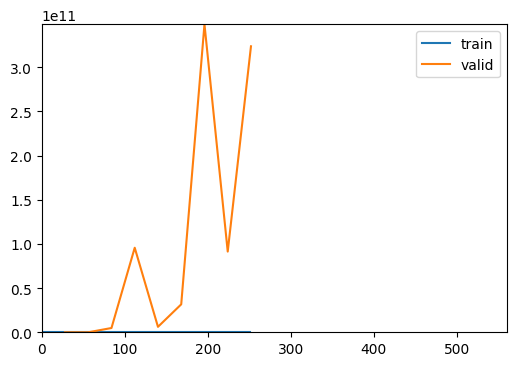

KeyboardInterrupt: 

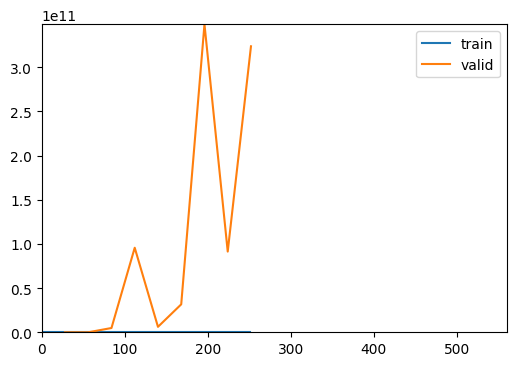

In [15]:
learn.fine_tune(20, 0.3, cbs=[
    ShowGraphCallback(),
]) #epochs and learning rate

In [ ]:
### Conclusion: I am overfitting (need more labelled data ~ 100 images?); also 0.3 is too big a learning rate for convnext_tiny_hnf (i am oscillating!)

### Empty The GPU if you are using it!

In [7]:
import torch
print(torch.cuda.is_available())

torch.cuda.empty_cache()

False
